# Notebook 2: Input-Output Networks
#### Econometric Methods for Social Spillovers and Networks
#### University of St. Gallen, October 7th to October 11th, 2024
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the second of a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given at the St. Gallen University from October 7th to October 11th, 2024. The scripts below were written for Python 3.6. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.

#### Code citation:
Graham, Bryan S. (2020). "Notebook 2: Input-Output Networks: St. Gallen University Econometric Methods for Social Spillovers and Networks Course Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 20 December 2020)

## Sectoral productivity shocks and aggregate fluctuations

Daron Acemoglu , Vasco M. Carvalho, Asuman Ozdaglar and Alireza Tahbaz-Salehi (2012, _Econometrica_) study the relationship between intersectoral input-output linkages and the aggregate implications of sectoral level productivity shocks. Their work elegantly integates classic work on Input-Ouput (IO) models with modern network analysis. The notion of sectoral influence that emerges from their model is closely related to the PageRank centrality measure (which itself goes back to Leontief's original work). A comprehensive textbook introduction to Input-Output analysis can be found in Miller and Blair (2009).  

In this notebook we will construct and analyze an industry-by-industry direct requirements matrix: the $ \mathbf{A} $ matrix from input-output analysis. We will do this by using an industry-by-industry totals requirements matrix constructed by the Bureau of Economic Analysis (BEA) as part of their 2007 IO benchmark (the classic $ \left(\mathbf{I}-\mathbf{A}\right)^{-1} $ Leontief matrix from input-output analysis). The dataset is located in the "data" directory of the Github repository. You'll need to download the data and adjust the **data** directory defined below to run this notebook on your computer.    
<br>
This notebook also produces several figures. These are saved in the **graphics** directory defined below. This directory should also be modified prior to executing the notebook.
<br>
**References**    
<br>
Acemoglu, Daron, Carvalho, Vasco M., Ozdaglar, Asuman and Tahbaz-Salehi, Alireza. (2012). "The network origins of aggregate fluctuations", _Econometrica_ 80 (5): 1977 - 2016.    
<br>
Miller, Ronald E. and Blair, Peter D. (2009). _Input-Output Analysis: Foundations and Extensions_. Cambridge: Cambridge University Press.

In [4]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Main scientific computing modules
# Load library dependencies
import time
import numpy as np
import scipy as sp
import pandas as pd
import itertools as it

# Import matplotlib & seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# networkx module for the analysis of network data
import networkx as nx

Location of BEA benchmark data.

In [6]:
# Directory where graphics files will be saved (and where example data are stored)
data =     'C:/Users/bgrah/Dropbox/Teaching/Short_Courses/St_Gallen/2024/Data/'
graphics = 'C:/Users/bgrah/Dropbox/Teaching/Short_Courses/St_Gallen/2024/Graphics/'

This is a short piece of utility code for kernel density estimation.

In [8]:
def kde(Y, y_grid, h = None, smooth_factor = 1, s_wgt=None):
    
    N      = len(Y)                     # Number of observations
    N_grid = len(y_grid)                # Number of evaluation points
    Y      = Y.reshape((N,1))           # Reshape Y into N x 1 numpy array
    y_grid = y_grid.reshape((1,N_grid)) # Reshape y_grid into 1 x N_grid numpy array
    
    # Set bandwidth value if needed
    if h is None:
        iqr   = np.subtract.reduce(np.percentile(Y, [75,25]))  # inter-quartile range, returned as scalar
        sigma = np.std(Y, ddof=1)                              # standard deviation
        A     = min(sigma, iqr/1.349)                          # pick smallest of two dispersion measures
        h     = smooth_factor * 0.9 * A * N ** (-1/5.)         # Silverman's rule-of-thumb times additional
                                                               # user-supplied under/over smoothing factor
    # Form N x N_grid matrix with elements K((Y-y)/h)/h
    k = sp.stats.norm.pdf((Y - y_grid)/h)/h
    
    # Take column sums of k to get kernel density estimate at each of the N_grid points
    # Put results in N_grid x 2 array with y_grid in column 1 and f_hat in column 2
    f_hat = np.vstack((np.ravel(y_grid), np.average(k, axis=0, weights=s_wgt))).T
    
    # Sort results by y_grid values, smallest to largest (facilitates plotting)
    f_hat = f_hat[f_hat[:, 0].argsort()]
    
    return [f_hat, h]

We begin by loading the 2007 Industry-by-Industry _Total_ Requirements Table constructed by the Bureau of Economic Analysis (BEA). This is made available as a Microsoft Excel workbook by the BEA. The _openpyxl_ module is good for working with MS Excel files. The source data is available online [here](https://www.bea.gov/industry/input-output-accounts-data).

In [10]:
# Use openpyxl module to work with MS Excel workbook data
# NOTE: This makes it easy to move across different sheets and cells

import openpyxl
wb        = openpyxl.load_workbook(data+'IxI_TR_2007_Detail.xlsx')  # Industry-by-Industry Total Requirements Table
io_matrix = wb['2007']                                              # Actual N x N table in '2007' sheet

This next block of code extracts data from the BEA MS Excel workbook. It constructs three objects.    

First it constructs a dictionary with spreadsheet row numbers as _keys_ and a second dictionary as _items_. The second dictionary contains the NAICS code for the sector, a descriptive sector name, and a place-holder for the centrality measure defined by Acemoglu et al. (2012). This measure is called _influence_ and defined in Equation (4) of their paper.    

Second it extracts the $\mathbf{L} = \left(\mathbf{I}-\mathbf{A}\right)^{-1} $ total requirements matrix from the workbook. It then recovers the direct requirements matrix by calculating $\mathbf{A} = \left(\mathbf{I}-\mathbf{L}\right)\mathbf{L}^{-1} $.    

Third it constructs an edge dictionary. This is later used to construct a weighted digraph object in _networkx_.

In [12]:
# Create empty dictionaries to store input-output network in
N = 389                  # Number of industries in 2007 benchmark files 
T = np.zeros((N,N))      # Initialize industry-by-industry total requirements matrix
io_edges = []            # Tuples of form (i, j, {a_ij, w_ij})
io_industries = {}       # Dictionary of sector names

#-----------------------------------------------------------------#
#- CONSTRUCT INPUT-OUTPUT DIRECT REQUIREMENTS DICTIONARY         -#
#-----------------------------------------------------------------#

# Extract total requirements matrix from excel worksheet
# NOTE: first element is in row 6, column 3
for i in range(0, N):
    
    # Get NAICS code and name of industry i
    code_i = str(io_matrix.cell(row = i + 6, column = 1).value)
    name_i = str(io_matrix.cell(row = i + 6, column = 2).value)
    io_industries[i] = {'code' : code_i, 'name' : name_i, 'influence' : 0}
    
    for j in range(0, N):
        
        # Build up total requirements matrix (i.e., Leontief inverse)
        T[i,j] = io_matrix.cell(row = i + 6, column = j + 3).value
        
# Use matrix inversion to recover underlying direct requirements matrix
# cf., Acemoglu et al. (2012, Econometrica)
A = (T - np.identity(N)) @ np.linalg.inv(T)

# The A matrix gives the amount of input from the column industry j (the supplier)
# purchased by the row industry i (the buyer)

# Next construct a dictionary of edges with direct requirements coefficients
# NOTE: w_ij = sales from j-to-i divided by total sales of i
for i in range(0, N):
    for j in range(0, N):
        supplier = str(io_matrix.cell(row = i + 6, column = 1).value)
        buyer    = str(io_matrix.cell(row = 5, column = j + 3).value)
        io_edges.append((supplier, buyer, {'a_ij' : A[i,j], \
                                           'w_ij' : A[i,j]/np.sum(A[:,i]) if np.sum(A[:,i]) > 0 else 0}))

The next block of code removes the "private households" sector for the analysis (it is akin to a dangling node). Specifically it does not draw inputs from, or source inputs to, any other sector.

In [14]:
# Remove private household ('814000') sector from items constructed above
# Find row/column index for private households
i_pv = [i for i, item in io_industries.items() if item['code'] == '814000'][0]

# Remove ith row and column from A matrix
A = np.delete(A, (i_pv), axis=0)
A = np.delete(A, (i_pv), axis=1)

# Remove private households from industries dictionary
io_industries.pop(i_pv, None)

# Remove any edges in io_edge involving private household sector
io_edges = [(i, j, attr) for (i, j, attr) in io_edges if (i != '814000') & (j != '814000')]

# Decrement number of industries by 1
N -= 1  

Save the directs requirement matrix for use elsewhere.

In [16]:
USDirectRequirementsMatrix = np.matrix(A)
USDirectRequirementsMatrix.dump(data+"USDirectRequirementsMatrix.dat")

The next snippet of code calculates the _influence_ vector defined in Equation (4) of the Acemoglu et al. (2012) paper. Their model assumes that all industries have the identical intermediate input shares (which is not true in practice). For the purposes of calculation I set $ \alpha=0.55 $, which is close to the average intermediate input shares across all industries. 

In [18]:
# Calculate influence vector, v (Equation (4) of Acemoglu et al (2012, Econometrica))
alpha = 0.55                          # Approximate mean intermediate input share (see below)
W     = A / np.sum(A, axis = 0)       # This is W.T in Acemoglu et al (2012, Econometrica)
v     = (alpha/N) * np.linalg.inv(np.identity(N) - (1-alpha)*W) @ np.ones((N,1))

Next I put the calculated influence values into the **io_industries** dictionary.

In [20]:
i = 0
for industry in io_industries:
    io_industries[industry]['influence'] = v[i,0]
    i += 1

This block of code lists the most influential sectors according the Acemoglu et al. (2012) measure. Loosely speaking these sectors are key input suppliers (or suppliers of such suppliers). The paper shows how sector-specific TFP shocks may have macro effects. This makes sense. It is sensible, for example, that if electrical production became more efficient, that many other sectors would benefit.

In [22]:
import operator

RankedIndustries = [[item['code'], item['name'], item['influence']] for i, item in io_industries.items()]
RankedIndustries = sorted(RankedIndustries, key=operator.itemgetter(2), reverse=True)[:10]

print("%s %s %s" % ('NAICS'.ljust(10), 'SECTOR NAME'.ljust(60), 'INFLUENCE'.rjust(8)))
print("--------------------------------------------------------------------------------------")
for industry in RankedIndustries:
    print("%s %s %s" % (industry[0].ljust(10), industry[1].ljust(60), str(industry[2]).rjust(8)))

NAICS      SECTOR NAME                                                  INFLUENCE
--------------------------------------------------------------------------------------
420000     Wholesale trade                                              0.028985531888752924
550000     Management of companies and enterprises                      0.020670478669332328
531ORE     Other real estate                                            0.019640784155145648
324110     Petroleum refineries                                         0.015291076182945583
211000     Oil and gas extraction                                       0.014598514354446854
331110     Iron and steel mills and ferroalloy manufacturing            0.012569210947277313
52A000     Monetary authorities and depository credit intermediation    0.010364680457071793
524100     Insurance carriers                                           0.008245068890299445
484000     Truck transportation                                         0.0080393580581

## Visualization of the Input-Output Production Network

These next few blocks of code create and plot a _networkx_ digraph object. For the purposes of visualization I only include edges between sectors where the supplying sector accounts for least 5 percent of all intermediate input purchases by the buying sector. This, of course, makes the resulting network sparser and focuses our attention on more consequential "supply" relationships.

In [24]:
G = nx.DiGraph(year='2007')
for (i, j, attr) in io_edges:
    if attr['w_ij'] >=0.05:
        G.add_edge(i, j)

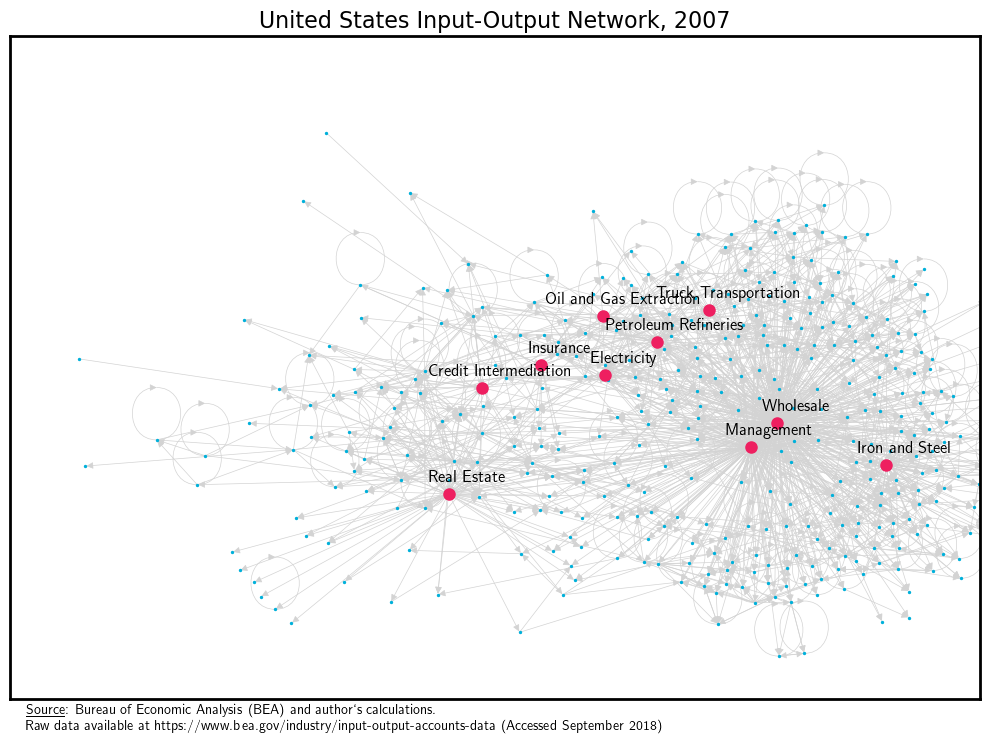

In [25]:
# Plot input-ouyput network
fig_IO_network, ax = plt.subplots(ncols=1, figsize=(10, 7.5))

# Use Graphviz to position nodes
node_pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')

# Adjust positions of nodes labels
offset = 25
pos_labels = {}
nodes = node_pos.keys()
for node in nodes:
    x, y = node_pos[node]
    pos_labels[node] = (x + offset, y + offset)

# Plot network
from matplotlib import rc
rc('text', usetex=True)
plt.text(-30, -75, r'\underline{Source}: Bureau of Economic Analysis (BEA) and author`s calculations.', fontsize=10)
plt.text(-30, -100, r'Raw data available at https://www.bea.gov/industry/input-output-accounts-data (Accessed September 2018)', fontsize=10)

nx.draw_networkx(G, pos=node_pos, with_labels=False, \
                 edge_color='lightgrey', width=0.5, node_size=2, node_color='#00B0DA')

# Top 10 Sectors
TopTen2007 = {'420000' : r'Wholesale', '550000' : r'Management', '531ORE' : r'Real Estate', \
              '324110' : r'Petroleum Refineries', '211000' : r'Oil and Gas Extraction', \
              '331110' : r'Iron and Steel', '52A000' : r'Credit Intermediation', \
              '524100' : r'Insurance', '484000' : r'Truck Transportation', '221100' : r'Electricity'}

nx.draw_networkx_nodes(G, pos=node_pos, \
                       nodelist=['420000','550000','531ORE','324110','211000','331110','52A000',\
                                 '524100','484000','221100'], node_size=64, node_color='#EE1F60')

nx.draw_networkx_labels(G, pos=pos_labels, labels=TopTen2007, font_size=12, font_weight='black')

# Set axis limits and suppress tick marks
plt.ylim([-50,1000])
plt.xlim([-50,1200])

plt.title('United States Input-Output Network, 2007', fontsize=16)

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)

# Remove tick marks and labels
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
    
# Save figure
plt.tight_layout()
plt.savefig(graphics + 'USInputOutput2007', bbox_inches='tight', dpi=500) 

We end our analysis by plotting the in degree distribution (based upon the $ \mathbf{A} $ matrix). Contrary to the model this shows a fare amount of variation in the role played by intermediate inputs across sectors.   

We also plot the outdegree distribution (based on the column sum normalized $ \mathbf{A} $ matrix). The distribution of out degree is right-skewed, with a thick tail of high out degree sectors (i.e., important input supplying sectors). This is consistent with the main empirical point of the Acemoglu et al. (2012) paper.

Input-Output Network Weighted In Degree Distribution
NOTE: In degree coincides with the intermediate input share in this context

Mean In Degree      : 0.5507
Std. Dev. In Degree : 0.1652
Min In Degree       : 0.0878
Max In Degree       : 1.0406


Input-Output Network Weighted Out Degree Distribution

Mean Out Degree      : 1.1191
Std. Dev. Out Degree : 3.0451
Min Out Degree       : 0.0000
Max Out Degree       : 49.7249


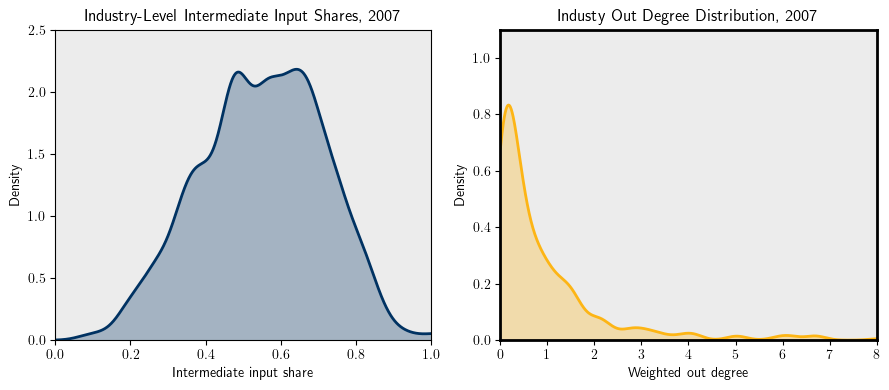

In [27]:
G = nx.DiGraph(year='2007')
G.add_edges_from(io_edges)

# Weighted in degree sequence of input-ouput network as Pandas series
in_degree_sequence = pd.Series(sorted(list(dict(G.in_degree(weight='a_ij')).values()),reverse=True))   # In degree
out_degree_sequence = pd.Series(sorted(list(dict(G.out_degree(weight='w_ij')).values()),reverse=True)) # Out degree

N = len(in_degree_sequence) # Number of industries

print("Input-Output Network Weighted In Degree Distribution")
print("NOTE: In degree coincides with the intermediate input share in this context")
print("")
print("Mean In Degree      : " + "%3.4f" % np.mean(in_degree_sequence))                # Mean In Degree
print("Std. Dev. In Degree : " + "%3.4f" % np.std(in_degree_sequence))                 # Std. of In Degree
print("Min In Degree       : " + "%3.4f" % np.min(in_degree_sequence))                 # Min of In Degree
print("Max In Degree       : " + "%3.4f" % np.max(in_degree_sequence))                 # Max of In Degree
print("")
print("")
print("Input-Output Network Weighted Out Degree Distribution")
print("")
print("Mean Out Degree      : " + "%3.4f" % np.mean(out_degree_sequence))               # Mean Out Degree
print("Std. Dev. Out Degree : " + "%3.4f" % np.std(out_degree_sequence))                # Std. of Out Degree
print("Min Out Degree       : " + "%3.4f" % np.min(out_degree_sequence))                # Min of Out Degree
print("Max Out Degree       : " + "%3.4f" % np.max(out_degree_sequence))                # Max of Out Degree


# Plot In- and Out Degree Distributions
# Define figure object
fig, sbp = plt.subplots(ncols=2, figsize=(9, 4))
ax1 = sbp[0] # Handle for left subplot
ax2 = sbp[1] # Handle for right subplot

# Computer in degree kernel density estimate
[f_id, bw] = kde(in_degree_sequence.values, np.arange(0,1,0.001), h=None, smooth_factor=3/4, s_wgt=None)  
[f_od, bw] = kde(out_degree_sequence.values, np.arange(0,8,0.01), h=None, smooth_factor=1, s_wgt=None)  

plt.sca(ax1) # Select first subplot
plt.plot(f_id[:,0], f_id[:,1], color = '#003262', linewidth = 2, label  = 'Input Share')
ax1.fill_between(f_id[:,0], f_id[:,1], facecolor='#003262', alpha=0.3, interpolate=True) 

# Set axis limits 
plt.ylim([0,2.5])
plt.xlim([0,1])

plt.title('Industry-Level Intermediate Input Shares, 2007', fontsize=12)
plt.xlabel('Intermediate input share')
plt.ylabel('Density')

# Clean up the plot, add frames etc.
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)

plt.sca(ax2) # Select second subplot    
plt.plot(f_od[:,0], f_od[:,1], color = '#FDB515', linewidth = 2, label  = 'Out Degree')
ax2.fill_between(f_od[:,0], f_od[:,1], facecolor='#FDB515', alpha=0.3, interpolate=True)

# Set axis limits 
plt.ylim([0,1.1])
plt.xlim([0,8])

plt.title('Industy Out Degree Distribution, 2007', fontsize=12)
plt.xlabel('Weighted out degree')
plt.ylabel('Density')

# Clean up the plot, add frames etc.
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
    
# Save figure
plt.tight_layout()
plt.savefig(graphics + 'USInputOutput2007_DegreeDis', bbox_inches='tight', dpi=500)

In [28]:
# This imports an attractive notebook style from Github
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen('http://bit.ly/1Bf5Hft')
HTML(html.read().decode('utf-8'))